# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings("ignore")
import time
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import graphviz

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [2]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""
SELECT * FROM Reviews order by Time
""", con) 
final_train = pd.read_sql_query("""
SELECT * FROM Reviews order by Time 
limit cast(0.7*(select count(*) from Reviews) as integer) 
""" , con) 
final_test = pd.read_sql_query("""
SELECT * FROM Reviews order by Time desc
limit cast(0.3*(select count(*) from Reviews) as integer) 
""" , con)

In [3]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [4]:
final_train['Score'] = final_train['Score'].replace('positive',1)
final_train['Score'] = final_train['Score'].replace('negative',0)
final_test['Score'] = final_test['Score'].replace('positive',1)
final_test['Score'] = final_test['Score'].replace('negative',0)
final_train.head(20)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
5,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
6,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
7,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
8,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
9,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...


In [5]:
print(final.shape)
print(final_train.shape)
print(final_test.shape)

(364171, 12)
(254919, 12)
(109251, 12)


In [6]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# [7.2.2] Bag of Words (BoW)

In [7]:

from sklearn.preprocessing import normalize
count_vect = CountVectorizer() #in scikit-learn
final_train_X = count_vect.fit_transform(final_train['CleanedText'].values)
final_train_Y = final_train['Score'].values
final_test_X =  count_vect.transform(final_test['CleanedText'].values)
final_test_Y = final_test['Score'].values

final_train_X = normalize(final_train_X, norm='l1', axis=0)
final_test_X = normalize(final_test_X, norm='l1', axis=0)

unique, counts = np.unique(final_train_Y, return_counts=True)
print("final_train_Y distribution: %s" % dict(zip(unique, counts)))
unique, counts = np.unique(final_test_Y, return_counts=True)
print("final_test_Y distribution: %s" % dict(zip(unique, counts)))
print("So sampling required on the dataset as it has less number of negative datapoints")

final_train_Y distribution: {0: 38029, 1: 216890}
final_test_Y distribution: {0: 19077, 1: 90174}
So sampling required on the dataset as it has less number of negative datapoints


In [8]:
print("the type of count vectorizer ",type(final_train_X))

the type of count vectorizer  <class 'scipy.sparse.csc.csc_matrix'>


In [9]:
#GridSearchCV to find optimal min_samples_split and max_depth
final_train_X_20000=final_train_X[0:20000]
final_train_Y_20000=final_train_Y[0:20000]
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
start = datetime.now()

tuned_parameters = {'n_estimators'      : [i for i in range(485,496,5)],
                    'max_depth'         : [i for i in range(8,11,2)]}
                     #'min_samples_leaf'  : [i for i in range(1,10,2)],
                     #'min_samples_split' : [i for i in range(2,10,2)]}

model = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_grid=tuned_parameters, 
                     scoring = 'roc_auc', cv=3, verbose=True, n_jobs=3)
model.fit(final_train_X_20000, final_train_Y_20000)
print(model.best_estimator_)
end = datetime.now()
print("Total running time: %s" % (end - start))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:  1.7min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=485, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Total running time: 0:01:54.432736


Postive top 10 important features are:
('great', 0.0294845501084768)
('disappoint', 0.015528900076454483)
('bad', 0.013883502754390594)
('perfect', 0.013716919167583849)
('love', 0.013131938185478467)
('delici', 0.012173786735142834)
('best', 0.011519300717570121)
('return', 0.010726530252038893)
('money', 0.008808225600792143)
('terribl', 0.008728618407852306)


Word Cloud for Important features


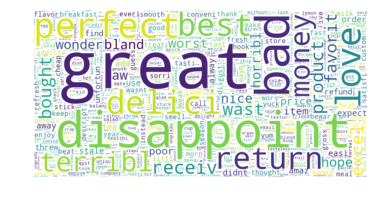

In [10]:
#Inportant features and WordCloud representation
import operator
from sklearn.tree.export import export_graphviz

feature_names= count_vect.get_feature_names()
feat_importance = model.best_estimator_.feature_importances_
imp_features = {}
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = feat_importance[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

list_of_words=[]
for i in range(len(names_diff_sorted)):
    for j in range(int(names_diff_sorted[i][1]*1000000)):
        list_of_words.append(names_diff_sorted[i][0])
list_of_words_str = ' '.join(list_of_words)

wc = WordCloud(background_color="white", max_words=len(list_of_words), 
               width=800, height=400, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   25.9s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   32.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   53.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   54.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   56.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   57.7s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.1min finished



The optimal value of n_estimators is 500.


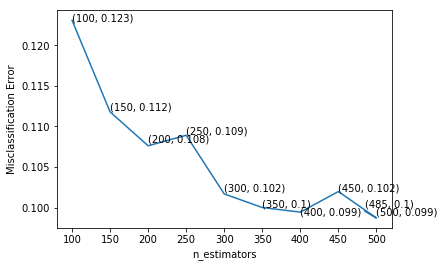

the misclassification error for each n_estimators value is :  [0.123 0.112 0.108 0.109 0.102 0.1   0.099 0.102 0.099 0.1  ]


In [11]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

cv_scores = []
MSE = []
tuned_parameters['n_estimators'] = [i for i in range(100,501,50)]+[485]

# perform 10-fold cross validation
for k in tuned_parameters['n_estimators']:
    #print(time.time())
    nb = RandomForestClassifier(n_estimators=k, max_depth=model.best_estimator_.max_depth,
                                class_weight='balanced')
    nb.fit(final_train_X_20000, final_train_Y_20000)
    scores = cross_val_score(estimator=nb, X=final_train_X_20000, y=final_train_Y_20000, 
                             cv=10, scoring='roc_auc', verbose=True, n_jobs = 3)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['n_estimators'][MSE.index(min(MSE))]
print('\nThe optimal value of n_estimators is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['n_estimators'], MSE)

for xy in zip(tuned_parameters['n_estimators'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('n_estimators')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each n_estimators value is : ", np.round(MSE,3))

In [12]:
final_test_X_20000=final_test_X[0:20000]
final_test_Y_20000=final_test_Y[0:20000]

Accuracy of the model when number of tree = 485 is:  86.140000%
Confusion matrix for the model is:


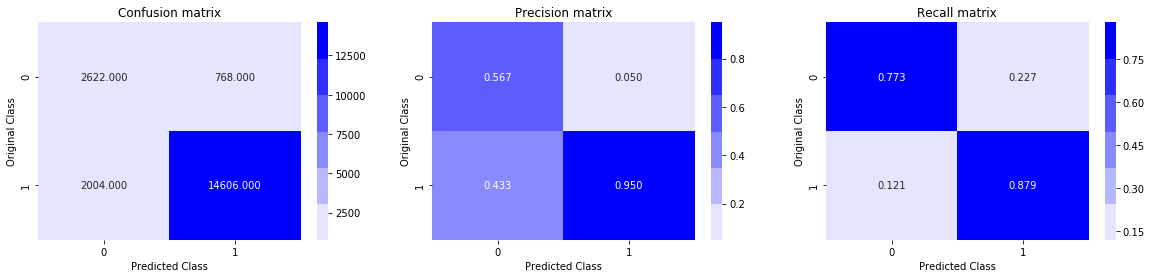

Recall value for the positive class of the model is: 0.8793497892835641
Precision value for the positive class of the model is: 0.9500455314166775
F1 score for the positive class of the model is: 0.9133316658329165


In [13]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.best_estimator_.predict(final_test_X_20000)
Y_test_accuracy = accuracy_score(final_test_Y_20000, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model when number of tree = %d is:  %f%%' 
      % (model.best_estimator_.n_estimators, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y_20000, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y_20000, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)


In [14]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_grid_bow_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y_20000
y_scores=model.best_estimator_.predict(final_train_X_20000)

final_grid_bow_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y_20000
y_scores=model.best_estimator_.predict(final_test_X_20000)

final_grid_bow_test_err=print_auc_score(y_true, y_scores)

print(final_grid_bow_est)
print(final_grid_bow_train_err)
print(final_grid_bow_test_err)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=485, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
87.92136208638942
82.64005583585963


TF-IDF

In [15]:
final_test_X_20000=final_test_X[0:20000]
final_test_Y_20000=final_test_Y[0:20000]

In [16]:
from sklearn.preprocessing import normalize
tf_idf_vect = TfidfVectorizer()
final_train_X = tf_idf_vect.fit_transform(final_train['CleanedText'].values)
to_pass_tfidf_w2v_train = final_train_X
final_train_Y = final_train['Score'].values
final_test_X =  tf_idf_vect.transform(final_test['CleanedText'].values)
to_pass_tfidf_w2v_test = final_test_X
final_test_Y = final_test['Score'].values
final_train_X = normalize(final_train_X, norm='l1', axis=0)
final_test_X = normalize(final_test_X, norm='l1', axis=0)

unique, counts = np.unique(final_train_Y, return_counts=True)
print("final_train_Y distribution: %s" % dict(zip(unique, counts)))
unique, counts = np.unique(final_test_Y, return_counts=True)
print("final_test_Y distribution: %s" % dict(zip(unique, counts)))
print("So sampling required on the dataset as it has less number of negative datapoints")

final_train_Y distribution: {0: 38029, 1: 216890}
final_test_Y distribution: {0: 19077, 1: 90174}
So sampling required on the dataset as it has less number of negative datapoints


In [17]:
final_test_X_20000=final_test_X[0:20000]
final_test_Y_20000=final_test_Y[0:20000]
#RandomizedSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
start = datetime.now()

tuned_parameters = {'n_estimators'      : [i for i in range(400,501,25)],
                    'max_depth'         : [i for i in range(12,21,4)]}
                     #'min_samples_leaf'  : [i for i in range(1,10,2)],
                     #'min_samples_split' : [i for i in range(2,10,2)]}

model = RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_distributions=tuned_parameters, 
                           scoring = 'roc_auc', cv=3, verbose=True, n_jobs=3)
model.fit(final_train_X_20000, final_train_Y_20000)
print(model.best_estimator_)
end = datetime.now()
print("Total running time: %s" % (end - start))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  5.4min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=475, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Total running time: 0:05:50.564688


Postive top 10 important features are:
('disappoint', 0.018734842116054657)
('great', 0.01462502929129301)
('delici', 0.01459695413921144)
('love', 0.013302332638088155)
('would', 0.012721153947807916)
('best', 0.012275785509920787)
('favorit', 0.01042617629861141)
('away', 0.009050471552357263)
('didnt', 0.008887289790172507)
('bad', 0.008460504099690284)


Word Cloud for Important features


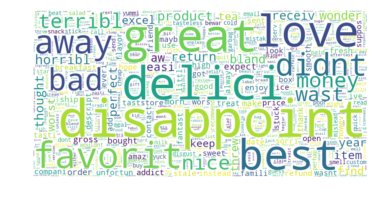

In [18]:
#Inportant features and WordCloud representation
import operator
from sklearn.tree.export import export_graphviz

feature_names= tf_idf_vect.get_feature_names()
feat_importance = model.best_estimator_.feature_importances_
imp_features = {}
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = feat_importance[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

list_of_words=[]
for i in range(len(names_diff_sorted)):
    for j in range(int(names_diff_sorted[i][1]*1000000)):
        list_of_words.append(names_diff_sorted[i][0])
list_of_words_str = ' '.join(list_of_words)

wc = WordCloud(background_color="white", max_words=len(list_of_words), 
               width=800, height=400, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   20.9s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   42.5s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.0min finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.9min finished



The optimal value of n_estimators is 475.


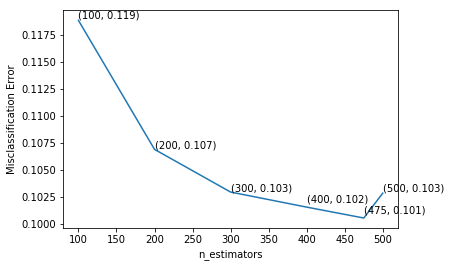

the misclassification error for each n_estimators value is :  [0.119 0.107 0.103 0.102 0.101 0.103]


In [19]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

cv_scores = []
MSE = []
tuned_parameters['n_estimators'] = sorted([i for i in range(100,501,100)]+[475])

# perform 10-fold cross validation
for k in tuned_parameters['n_estimators']:
    nb = RandomForestClassifier(n_estimators=k, max_depth=model.best_estimator_.max_depth,
                                class_weight='balanced')
    nb.fit(final_train_X_20000, final_train_Y_20000)
    scores = cross_val_score(estimator=nb, X=final_train_X_20000, y=final_train_Y_20000, 
                             cv=10, scoring='roc_auc', verbose=True, n_jobs = 3)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['n_estimators'][MSE.index(min(MSE))]
print('\nThe optimal value of n_estimators is %d.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(tuned_parameters['n_estimators'], MSE)

for xy in zip(tuned_parameters['n_estimators'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('n_estimators')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each n_estimators value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 12  and minimum sample split = 2 is:  87.110000%
Confusion matrix for the model is:


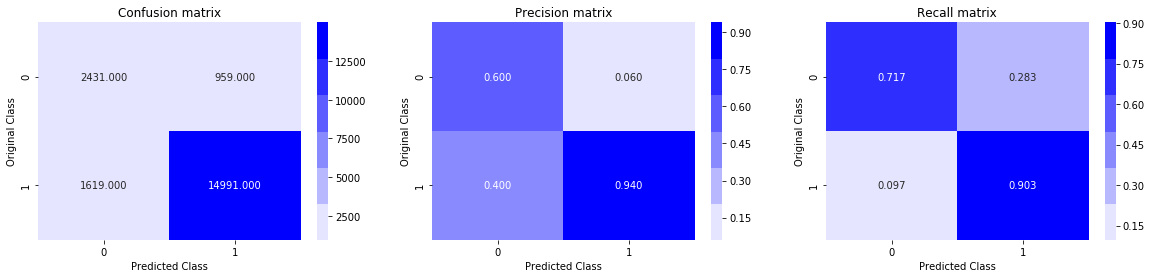

Recall value for the positive class of the model is: 0.902528597230584
Precision value for the positive class of the model is: 0.9398746081504702
F1 score for the positive class of the model is: 0.9208230958230958


In [20]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.best_estimator_.predict(final_test_X_20000)
Y_test_accuracy = accuracy_score(final_test_Y_20000, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y_20000, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y_20000, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [21]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_rand_tfidf_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y_20000
y_scores=model.best_estimator_.predict(final_train_X_20000)

final_rand_tfidf_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y_20000
y_scores=model.best_estimator_.predict(final_test_X_20000)

final_rand_tfidf_test_err=print_auc_score(y_true, y_scores)

print(final_rand_tfidf_est)
print(final_rand_tfidf_train_err)
print(final_rand_tfidf_test_err)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=475, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
88.72974633353947
80.98188708866783


The no of dimesion in BoW is very high, so it is observed that there is high misclassification error. Moreover the training process itself taking high amount of time.

Word2Vec

In [22]:
# Using Google News Word2Vectors
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('amazon-fine-food-reviews/GoogleNews-vectors-negative300.bin', binary=True)

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [23]:
# Train your own Word2Vec model using your own text corpus
import re
i=0
final_train_X=[]
final_train_Y=[]
for sents in final_train.values:
    filtered_sentence=[]
    #print(sents[final_train.columns.get_loc("CleanedText")])
    sent=cleanhtml(sents[final_train.columns.get_loc("CleanedText")])
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    final_train_X.append(filtered_sentence)
    final_train_Y.append(sents[final_train.columns.get_loc("Score")])
    

i=0
final_test_X=[]
final_test_Y=[]
for sents in final_test.values:
    filtered_sentence=[]
    #print(sents[final_train.columns.get_loc("CleanedText")])
    sent=cleanhtml(sents[final_test.columns.get_loc("CleanedText")])
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    final_test_X.append(filtered_sentence)
    final_test_Y.append(sents[final_test.columns.get_loc("Score")])

In [24]:
w2v_model=gensim.models.Word2Vec(final_train_X,min_count=5, workers=4, size =50)    #size=50,
print(w2v_model)
#print(final_train_X[1])
#w2v_model.wv[final_train_X[1][3]]

Word2Vec(vocab=18778, size=50, alpha=0.025)


Average W2V

In [25]:
# average Word2Vec
# compute average word2vec for each training review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in final_train_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
print(sent_vectors_train[1])


min_val=1
for i in range(0,len(sent_vectors_train)):
    for j in range(0,len(sent_vectors_train[0])):
        if sent_vectors_train[i][j] < min_val:
            min_val = sent_vectors_train[i][j]
        else:
            continue

            
# average Word2Vec
# compute average word2vec for each testing review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in final_test_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
print(sent_vectors_test[1])


min_val=1
for i in range(0,len(sent_vectors_test)):
    for j in range(0,len(sent_vectors_test[0])):
        if sent_vectors_test[i][j] < min_val:
            min_val = sent_vectors_test[i][j]
        else:
            continue

254919
50
[-0.13823092  0.37869374 -0.90587037 -1.11465138 -0.83261446 -0.0318299
  0.14138076  0.34714357  0.73997742 -0.18028401 -0.31281115 -0.80474131
 -0.33668264 -0.2527315  -0.0234566   0.76150927  0.62875023 -0.20284939
  0.53401727 -0.03060982  0.10915053  0.22458034 -0.15860097  0.12047485
 -0.70161632 -0.94763776  0.07588521 -0.07199348 -0.27870231  0.36851609
 -0.59904942 -0.26155795  0.48948596 -0.32570799  0.85362012 -0.03400204
  0.46922486 -0.16977514 -0.59666554 -0.3916211  -0.33252117 -0.22120316
 -0.57794406  0.37760492  0.19422391 -0.15675999 -0.12255366  0.67151338
 -0.50621062 -0.24782358]
109251
50
[-0.39650015  0.69182199  0.5305853  -1.47131346  1.29324371 -0.52455845
  0.33286391 -0.2673706   0.88111881  0.81024687  0.09027209 -0.62628695
 -0.6157742  -0.07669282 -1.87244073  1.30826706  1.16110357 -0.23404894
 -0.88068049  0.4044321   0.71798463  1.09266043  0.69859095 -0.05050305
 -0.78930837  0.40194587  0.50029597  0.29182397 -0.90844332  0.66870039
 -1.15

In [26]:
#We fould 1 review(19948) has all the vectors as Nan. So we are replacing it with 0
for i in range(len(sent_vectors_train)):
    for j in range(50):
        if sent_vectors_train[i][j] != sent_vectors_train[i][j]:
            sent_vectors_train[i][j]=0

In [27]:
for i in range(len(sent_vectors_test)):
    for j in range(50):
        if sent_vectors_test[i][j] != sent_vectors_test[i][j]:
            sent_vectors_test[i][j]=0

In [28]:
sent_vectors_train_20000=sent_vectors_train[0:20000]
sent_vectors_test_20000=sent_vectors_test[0:20000]

In [29]:
### GridSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
start = datetime.now()

tuned_parameters = {'n_estimators'      : [i for i in range(550,600,50)],
                    'max_depth'         : [i for i in range(30,40,5)]}
                     #'min_samples_leaf'  : [i for i in range(1,10,2)],
                     #'min_samples_split' : [i for i in range(2,10,2)]}
        
model = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_grid=tuned_parameters, 
                     scoring = 'roc_auc', cv=3, verbose=True, n_jobs=3)
model.fit(sent_vectors_train_20000, final_train_Y_20000)
print(model.best_estimator_)
end = datetime.now()
print("Total running time: %s" % (end - start))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:  2.5min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=35, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=550, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Total running time: 0:03:37.329223


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  3.5min finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  4.5min finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.2min finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.9min finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  6.2min finished



The optimal value of n_estimators is 500.


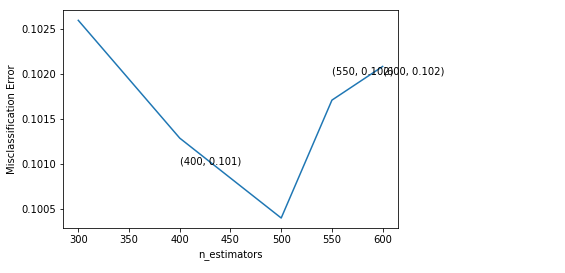

the misclassification error for each n_estimators value is :  [0.103 0.101 0.1   0.102 0.102]


In [30]:

from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []
MSE = []
tuned_parameters['n_estimators'] = sorted([i for i in range(300,601,100)]+[550])

# perform 10-fold cross validation
for k in tuned_parameters['n_estimators']:
    nb = RandomForestClassifier(max_depth=model.best_estimator_.max_depth, 
                                n_estimators=k, class_weight='balanced')
    nb.fit(sent_vectors_train_20000, final_train_Y_20000)
    scores = cross_val_score(estimator=nb, X=sent_vectors_train_20000, y=final_train_Y_20000, 
                             cv=10, scoring='roc_auc',verbose=True, n_jobs = 3)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['n_estimators'][MSE.index(min(MSE))]
print('\nThe optimal value of n_estimators is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['n_estimators'], MSE)

for xy in zip(tuned_parameters['n_estimators'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('n_estimators')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each n_estimators value is : ", np.round(MSE,3))

In [31]:
for i in range(len(sent_vectors_test)):
    for j in range(50):
        if sent_vectors_test[i][j] != sent_vectors_test[i][j]:
            sent_vectors_test[i][j]=0

Accuracy of the model at depth of the tree = 35  and minimum sample split = 2 is:  85.645000%
Confusion matrix for the model is:


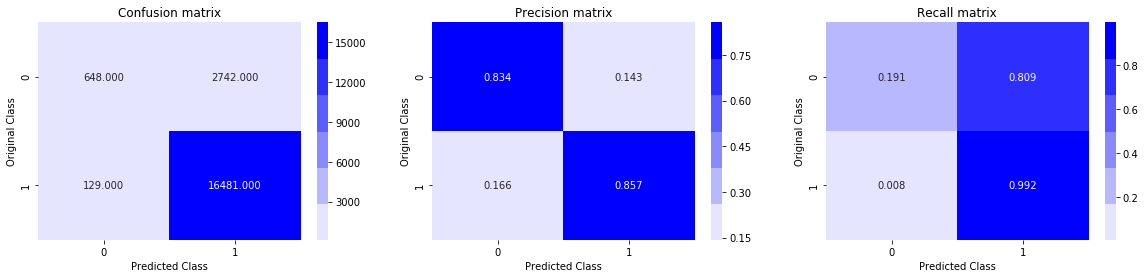

Recall value for the positive class of the model is: 0.9922335942203492
Precision value for the positive class of the model is: 0.8573583727826042
F1 score for the positive class of the model is: 0.9198783244495297


In [32]:

#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(sent_vectors_test_20000)
Y_test_accuracy = accuracy_score(final_test_Y_20000, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y_20000, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y_20000, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [33]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_grid_avgw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y_20000
y_scores=model.best_estimator_.predict(sent_vectors_train_20000)

final_grid_avgw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y_20000
y_scores=model.best_estimator_.predict(sent_vectors_test_20000)

final_grid_avgw2v_test_err=print_auc_score(y_true, y_scores)

print(final_grid_avgw2v_est)
print(final_grid_avgw2v_train_err)
print(final_grid_avgw2v_test_err)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=35, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=550, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
100.0
59.16920183491127
